In [1]:
%load_ext autoreload
%autoreload 2

_n_elements보다는 tile tensor처럼 {'stride':1, 'begin':-8, 'end': 8} 이런 식이 좋을 듯. 

In [2]:
import matplotlib.pyplot as plt 

import numpy as np
from cipher import *
from scheme import *

from algorithms import Algorithms 
from stats import Statistics

In [3]:
myring = Ring(seed=1234)
parms = Parameters(logp = 30, logq = 150, logn = 12)
nslots = 2**parms.logn
context = Context(parms, myring)

sk = context.generate_secret_key()

print(context.params)

 logp: 30
 logq: 150 
 logn: 12


In [4]:
keys = {"mult":context.generate_mult_key(),
        "rot":{'1':'hi1',
               '2':'hi2',
               '4':'hi4',
               '8':'hi8'}}
ev = Evaluator(keys, context) # Evaluator도 그냥 context만 넣게 할까? 

encoder = Encoder(context)
encryptor = Encryptor(context)

decryptor = Decryptor(sk)

arr = np.array([1,2,3,4,5,6,7,8])

ctxt = encryptor.encrypt(arr)

In [5]:
algo = Algorithms(ev, encoder)

st = Statistics(ev, encoder)

check = Checker()

### 자연로그

In [56]:
arr = np.linspace(0.1,1,8)
print(np.log(arr))

[-2.30258509 -1.47590652 -1.02961942 -0.72213472 -0.48729513 -0.29725152
 -0.13762138  0.        ]


### 로그 근사

In [57]:
def ln_approx(v):
    x = v-1
    x2 = x*x
    x4 = x2*x2
    x6 = x4*x2
    x8 = x4*x4
    return x - x2/2 + x*x2/3 - x4/4 + x*x4/5 - x6/6 + x/7 - x8/8 + x8*x/9

In [58]:
l_app = ln_approx(arr)

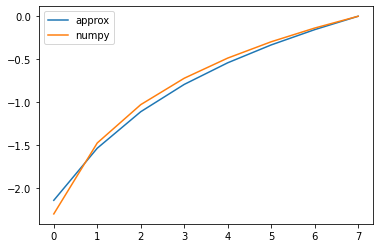

In [61]:
plt.plot(l_app, label="approx")
plt.plot(np.log(arr), label="numpy")
plt.legend()
plt.show()

### 로그 근사, 동형암호

In [6]:
def fun(x,y):
    return (x**2+y**2)**3

In [13]:
def fun_fhe_ver1(x,y):
    """pseudo code.
       *, +은 FHE 전용 연산을 표현
       x: scale = 30, level = 0
       y: scale = 30, level = 0
       1. 예제에서 input 변수의 'scale'은 기본값 30 (2^30)으로 가정
       2. 예제에서 input 변수의 mod(level)는 0으로 가정 
       3. 최대 곱셈 깊이를 도달하면 연산을 진행할 수 없고, bootstrapping이 필요함.
    """
    x2 = x*x 
    # 곱셈 후 x2.scale = x.scale + x.scale = 60으로 증가.
    rescale(x2) # 60 -> 30으로 scale down하면 대신 곱셈 깊이(level) 증가 (scale:30, level:1)
    y2 = y*y # (scale:60, level:0)
    rescale(y2) # 60 -> 30으로 scale down => (s:30, l:1)
    z = x2 + y2 # (s:30, l:1) 덧셈은 level 증가, scale 증가 없음, 
    z2 = z * z # (s:60, l:1)
    rescale(z2) # (s:30, l:2)
    
    moddown(z) # z2와 계산 가능하도록 임의로 level 상향. l1=1 -> l=2, (s:30, l:2)
    z3 = z2*z # == z * (z * z) => (s:60, l:2)
    return z3 # scale = 60인 암호문을 반환 

    # rescale(z3) # 최종 결과 scale down 할 수도 있고 안 할 수도 있음. 
    # rescale 여부는 컴파일러가 분석하여 계산 속도에 유리한 쪽으로 결정.    

1. Binary Op에서 암호문의 scale이 동일하고, 곱셈 깊이가 동일해야 연산 가능
2. 모든 연산은 Unary 혹은 Binary
3. scale이 작은 암호문의 계산 시간보다 scale이 큰 암호문의 계산 시간이 더 오래 걸림 (backend마다 다름)

In [14]:
def fun_fhe_ver2(x,y):
    x2 = x*x # (s:60, l=0)
    y2 = y*y # # (s:60, l=0)
    # !!! x2, y2 rescale skipped !!!
    z = x2 + y2 # (s:60, l:0)
    rescale(z) # (s:30, l:1)
    z2 = z*z # (s:60, l:1)
    rescale(z2) # (s:30, l:2)   
    moddown(z) # (s:30, l:2)
    
    z3 = z2*z # == z * (z * z) => (s:60, l:2)
    return z3 

- ver1에서는 rescale이 3회, ver2에서는 rescale이 2회 필요 
- 프로그램의 context에 따라 유리한 선택이 달라짐
- 따라서 컴파일러에서 최적화 필요
- 이 예제에서 최적화 cost는 operand의 `scale`, `level`, 그리고 `built-in function`들의 cost의 함수
- f_cost = f_cost(s1, s2, l1, l2, c_rescale, c_moddown, c_mult, c_add)
- 곱셈 연산은 operand의 `level`에 따라 속도가 달라짐
- c_mult = c_mult(l1,l2) 